In [35]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio openai-whisper spacy


In [36]:
import whisper
import gradio as gr
import spacy

In [37]:
model = whisper.load_model("base")

In [38]:
nlp = spacy.load("en_core_web_sm")

In [39]:
def extract_instructions(sentence):
    # parsing
    doc = nlp(sentence.lower())

    move_distance = None
    up_distance = None
    move_keywords = {"move", "go", "proceed", "advance", "forward", "ahead"}
    up_keywords = {"fly", "ascend", "up", "rise"}

    for token in doc:
      #intent
        if token.lemma_ in move_keywords and move_distance is None:
            for ent in doc.ents:
                if ent.label_ == "CARDINAL" and ent.start > token.i:
                    move_distance = float(ent.text)
                    break

        if token.lemma_ in up_keywords and up_distance is None:
            for ent in doc.ents:
                if ent.label_ == "CARDINAL" and ent.start > token.i:
                    up_distance = float(ent.text)
                    break

    # default
    move_distance = move_distance or 5.0
    up_distance = up_distance or 3.0

    return move_distance, up_distance

In [40]:
def transcribe_and_process(audio_path):
    result = model.transcribe(audio_path)
    transcription = result['text']

    move_distance, up_distance = extract_instructions(transcription)

    if move_distance and up_distance:
        response = f"Moving forward by {move_distance} meters and flying up by {up_distance} meters."
    elif move_distance:
        response = f"Moving forward by {move_distance} meters."
    elif up_distance:
        response = f"Flying up by {up_distance} meters."
    else:
        response = "No movement instruction detected."
    return transcription, response

In [41]:
iface = gr.Interface(
    fn=transcribe_and_process,
    inputs=gr.Audio(type="filepath"),
    outputs=[gr.Textbox(label="Transcription"), gr.Textbox(label="Command")],
    title="Robot Control Command Transcriber",
)

In [42]:
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://34c777547d18ec59d3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


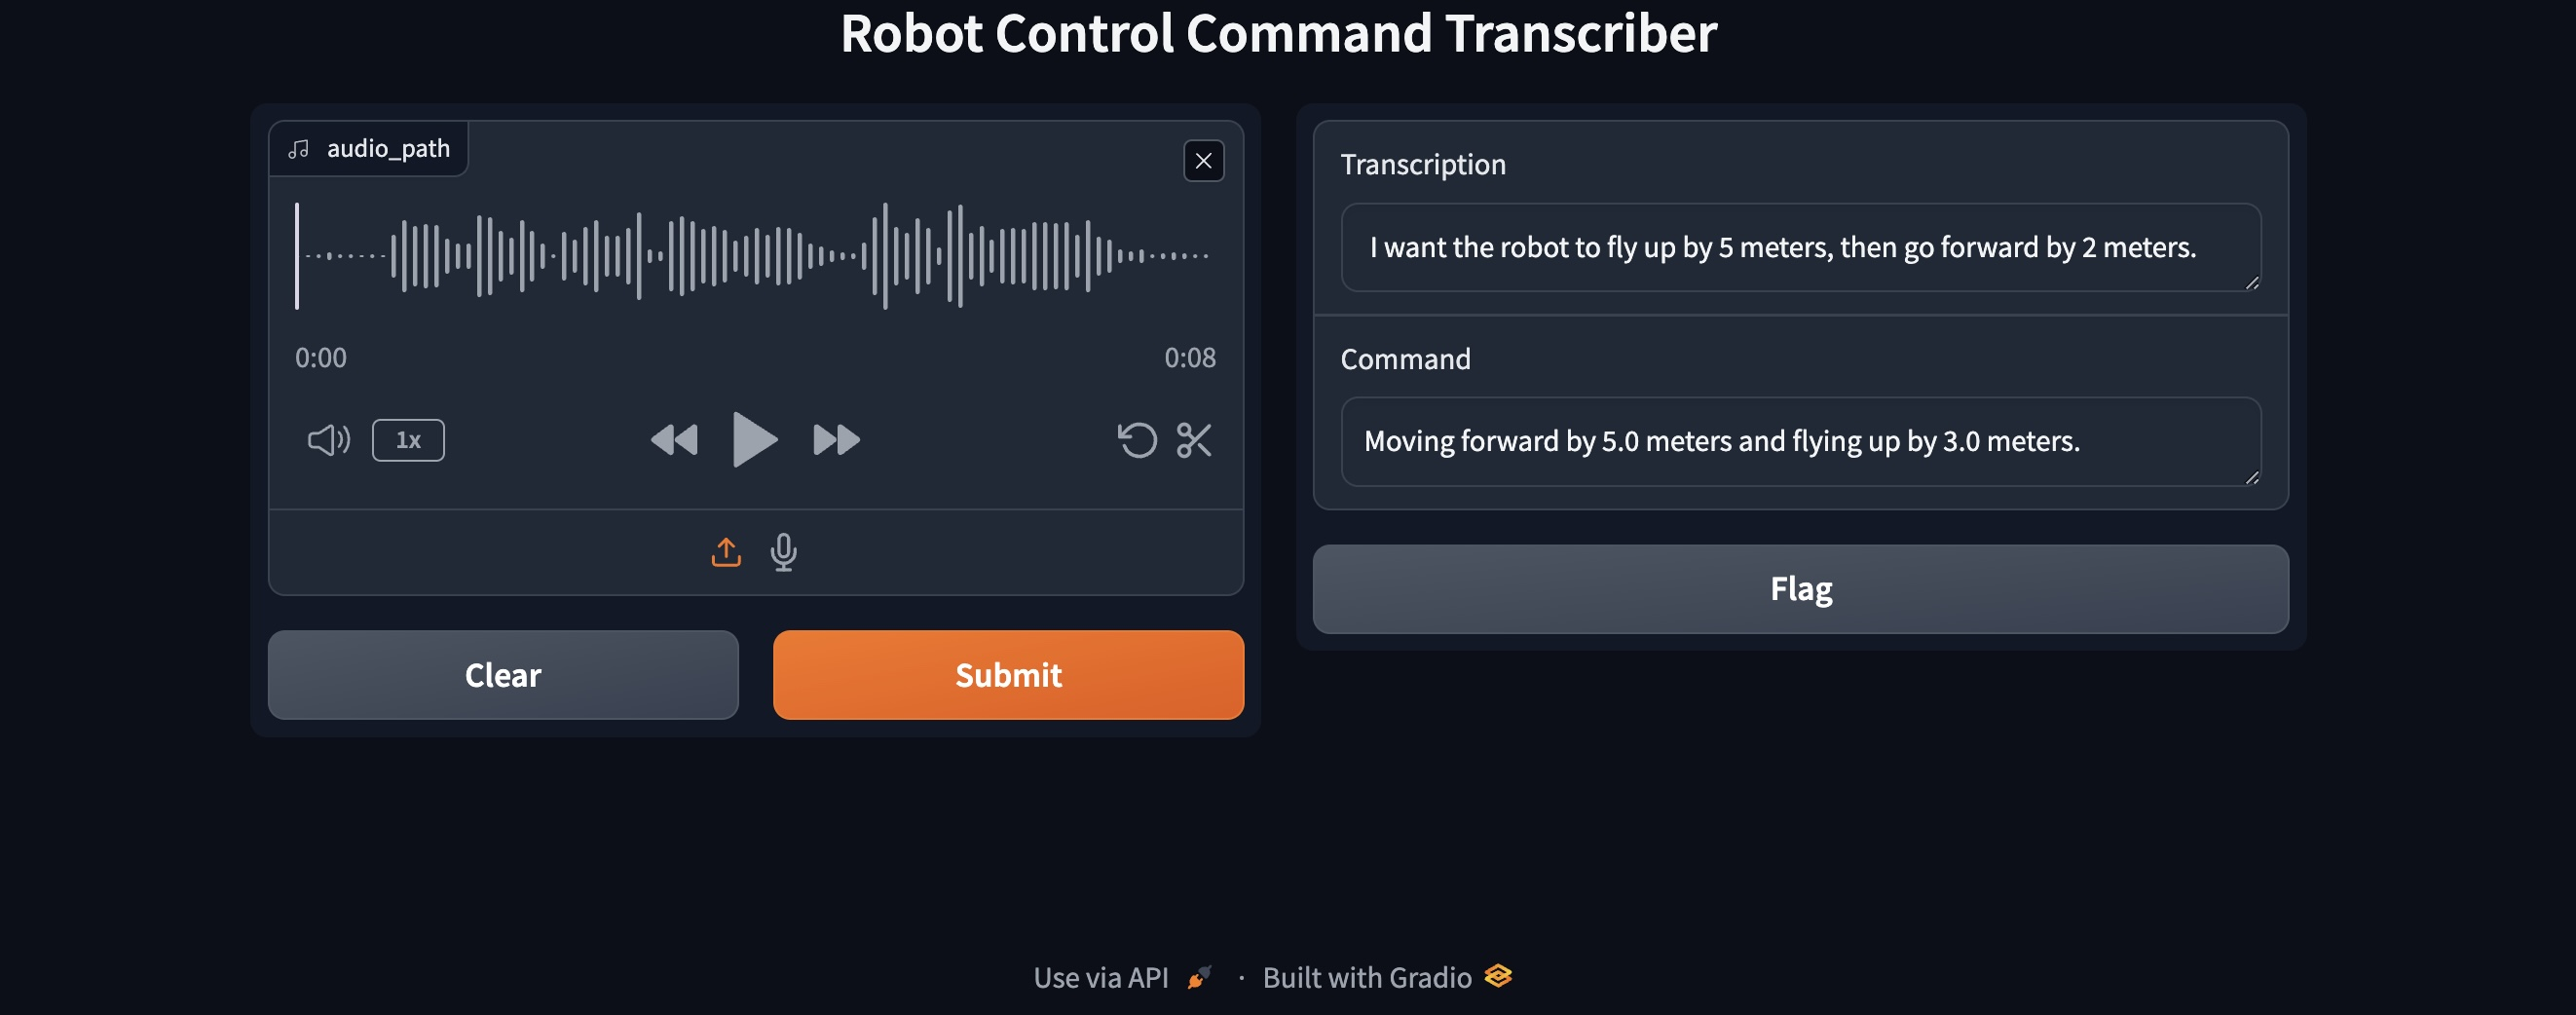